In [1]:
import pandas as pd
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt
import random

from scipy.optimize import minimize

import sys
sys.path.insert(0, '../scripts/')
import utils as utl

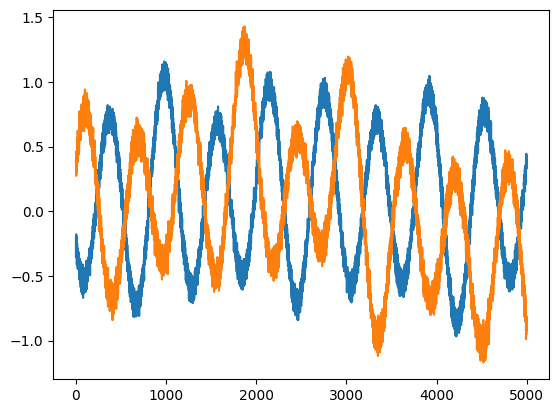

In [2]:
df = pd.read_csv('../data/1.raw/regression.csv')
X_cols = ['in_0', 'in_1', 'in_2', 'in_3', 'in_4']
y_col = ['out_0', 'out_1']

X = df[X_cols]
# for c in X.columns:
#     X[c] = utl.min_max_scaling(X[c])[0]

y = df.reset_index()[y_col]
# for c in y.columns:
#     y[c] = utl.min_max_scaling(y[c])[0]

plt.plot(y)

In [3]:
def init_w(m,n):
    w = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            w[i][j] = -1 + 2.0*random.random()
    return w

In [4]:
# __init__
inputs = len(X.columns)
M = 5
outputs = len(y.columns)
max_epochs = 100e3
basis_function = 'tanh'
factor = 1
# Initial weigths
w1 = factor*init_w(M, inputs+1)
w2 = factor*init_w(outputs, M+1)

w1_init = np.copy(w1)
w2_init = np.copy(w2)
thr = 1e-12
eta_b = 1e-3

In [5]:
def basis_transform(a: List, basis_function: str = 'sigmoid') -> pd.DataFrame:
    match basis_function:
        case 'sigmoid':
            for i in range(len(a)):
                a[i] = 1/(1+np.exp(-a[i]))
        case 'tanh':
            for i in range(len(a)):
                a[i] = np.tanh(a[i])    
    return a

In [6]:
def basis_derivative(a: List, basis_function: str = 'sigmoid') -> pd.DataFrame:
    match basis_function:
        case 'sigmoid':
            a_aux = a.copy()
            for i in range(len(a)):
                a_aux[i] = 1/(1+np.exp(-a[i]))
                a[i] = a_aux[i]*(1-a_aux[i])
        case 'tanh':
            for i in range(len(a)):
                a[i] = 1-np.tanh(a[i])**2
    return a

In [7]:
def predict_base(X: pd.DataFrame, w_g: List) -> List:
    X_mod = utl.add_bias_column(X)
    X_np = X_mod.to_numpy()

    a = []
    for i in range(len(w_g)):
        a.append((w_g[i]*X_np).sum(axis=1))
    return a, X_mod

def predict_sl(X: pd.DataFrame, w_g: List, basis_function: str = 'sigmoid') -> pd.DataFrame:
    a,_ = predict_base(X, w_g)
    a = basis_transform(a, basis_function= basis_function)    
    return pd.DataFrame(np.array(a).T)

def predict(X: pd.DataFrame) -> pd.DataFrame:
    h = predict_sl(X, w1, basis_function= basis_function)
    z = predict_sl(h, w2, basis_function= basis_function)
    return h,z

In [8]:
def error_backpropagation(X: pd.DataFrame, y: pd.DataFrame):
    # Model output
    h_pred, y_pred = predict(X)

    # Output error
    y_pred.columns = y.columns
    d = y_pred - y
    d_np = np.mean(d.to_numpy(),axis = 0)

    # Hidden layer error
    d_int_np = np.zeros((len(w2[0]),len(d_np)))
    Err2 = np.zeros((len(w2[0]),len(d_np)))

    # h'(aj)
    a,_ = predict_base(X, w1)
    z = predict_sl(X, w1, basis_function= basis_function).to_numpy()
    hp = basis_derivative(a, basis_function= basis_function)    
    h_ones = np.ones(len(hp[0]))
    hp.insert(0, h_ones)
    # delta hidden layer
    for i in range(len(w2[0])):
        for j in range(len(d_np)):
            d_int_np[i][j] = np.mean(hp[i]*np.mean(w2[:,i]*d_np[j]))
            Err2[i][j] = np.mean(z[i]*d_np[j])
    d_int_sum = np.mean(d_int_np, axis= 1)

    # Final error 
    X_np = utl.add_bias_column(X).to_numpy().T
    Err = np.zeros((len(w1[0]),len(d_int_sum)-1))
    for i in range(len(Err)):
        for j in range(1,len(Err[i])):
            Err[i][j-1] = np.mean(X_np[i]*np.mean(w1[:,i]*d_int_sum[j]))
    return np.mean(Err), Err, Err2, d_int_np, d_np

In [9]:
Err_T = 1.0
td = len(X)
eta = eta_b
counter = 0
while abs(Err_T) > thr and counter < max_epochs:
    Err_T, Err, Err2, d_int, d_np = error_backpropagation(X, y)    
    w1 = w1 - eta*Err.T
    w2 = w2 - eta*Err2.T
    Err_T = Err_T
    counter = counter + 1
    # print(Err_T)
    h_pred, y_pred = predict(X)
    # plt.plot(y)
    # plt.plot(y_pred)
    # plt.show()

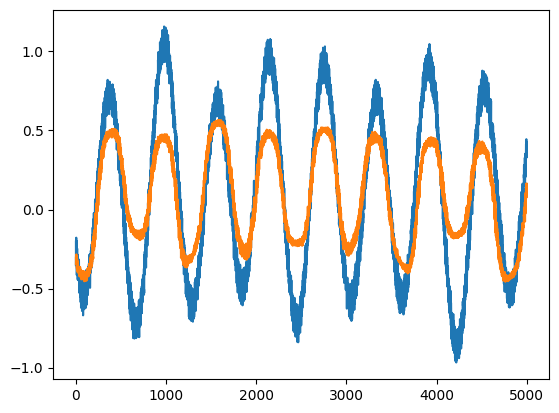

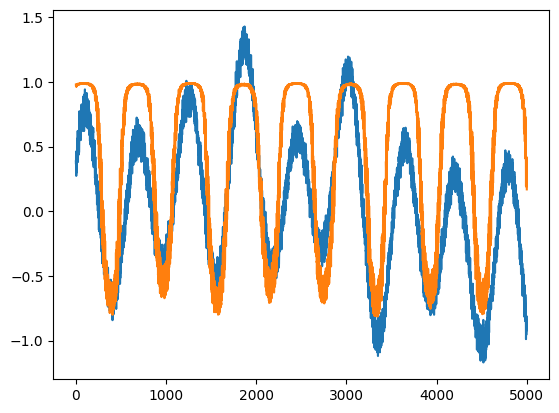

In [10]:
h_pred, y_pred = predict(X)
plt.plot(y.iloc[:,0])
plt.plot(y_pred.iloc[:,0])
plt.show()
plt.plot(y.iloc[:,1])
plt.plot(y_pred.iloc[:,1])
plt.show()